In [1]:
import pathlib
import cv2
import numpy as np
import pandas as pd
import ast
import re

from shutil import copy2

import matplotlib.pyplot as plt
from skimage import img_as_float
from mpl_toolkits.axes_grid1 import ImageGrid

def get_index_of_file(file_path, index):
    list_of_files = sorted(pathlib.Path(file_path).iterdir())
    f = list_of_files[index]
    try:
        f = int(f.stem)
    except ValueError:
        for current_file in list_of_files:
            if current_file.name[0] != '.':
                f = current_file
                break
        f = int(f.stem)
    return f

def get_files_list(file_path, transition_frames):
    files_list = list()
    start_int = get_index_of_file(file_path, 0)
    for i in transition_frames:
        files_list.append(str(pathlib.Path(file_path)
                      .joinpath('{:03d}.jpg'
                                .format(i+start_int))))
    return files_list

def copy_images(files_list):
    dirpath = pathlib.Path('/Volumes/NO NAME/sleeper/similar_sleep_pose/')
    for file in files_list:
        file = elect_pose_frame(file)
        p = pathlib.Path(file)
        
        file_path = "{}_{}".format(p.parts[-2],p.parts[-1])
        photo_number = (int(p.parts[-1].split('.')[0].split('-')[0]))
        
        new_file_path = dirpath.joinpath(file_path)
        print("COPYING: {}".format(new_file_path))
        copy2(file, new_file_path)

def process_date(folder_date, t_frames_list):
    files_list = get_files_list(folder_date, t_frames_list)
    copy_images(files_list)

def process_all(record, frames_list_str='reduced_std_frames'):
    for index, row in record.iterrows():
        dirpath = '/Volumes/NO NAME/sleeper/photos_processed/'
        p = pathlib.Path(dirpath)
        folder = p.joinpath(row['folder_name'])
        t_frames_list = row[frames_list_str]
        process_date(folder, t_frames_list)
        
record = pd.read_csv('/Volumes/NO NAME/sleeper/record.csv', index_col=0)
record = record[['folder_name','reduced_std_frames','count_reduced_std_frames']]
record['reduced_std_frames'] = record['reduced_std_frames'].apply(lambda x: ast.literal_eval(x))

record.head(2)

,folder_name,reduced_std_frames,count_reduced_std_frames
0,2019-02-18,"[1, 19, 26, 42, 50, 58, 72, 95, 110, 165, 173,...",13
1,2019-02-20,"[120, 182, 220, 228, 245]",5


In [47]:
def get_jump_file(file_path, jump):
    """
    file_path: in format: 2019-02-18/021.jpg 
    jump: number of files to jump_file
    
    """
    fp = pathlib.PurePath(file_path)
    file_number = int(fp.stem)
    jump_file_name  = fp.with_name('{:03d}.jpg'.format(file_number+jump))
    return str(jump_file_name)

def get_next_file(file_path):
    return get_jump_file(file_path, 1)

def read_and_normalize(f):
    scaling = 0.1
    img = cv2.imread(f, flags=cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, None,
                                 fx=scaling, fy=scaling, 
                                 interpolation=cv2.INTER_AREA)
    img = cv2.GaussianBlur(img,(7,7),0)
    img = cv2.normalize(img, None, alpha=0, beta=255, 
                                norm_type=cv2.NORM_MINMAX)
    return img

def elect_pose_frame(f, verbose=False, display_comparison=False):
    f1 = get_jump_file(f, 1)
    f2 = get_jump_file(f, 2)
    if not pathlib.Path(f1).exists() or not pathlib.Path(f2).exists():
        return f

    img_0 = read_and_normalize(f)
    img_1 = read_and_normalize(f1)
    img_2 = read_and_normalize(f2)
    
    diff_1_0 = np.sum(np.abs(img_1-img_0))
    diff_2_0 = np.sum(np.abs(img_2-img_0))
    diff_2_1 = np.sum(np.abs(img_2-img_1))
    
    if verbose:
        print(diff_1_0)
        print(diff_2_0)
        print(diff_2_1)
    
    # To show image triples
    if display_comparison:
        fig = plt.figure(1, (14., 10.))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(1, 3),  # creates 1x3 grid of axes
                     axes_pad=0.05,  # pad between axes in inch.
                     )
        for i,img in enumerate([img_0, img_1, img_2]):
            img = img_as_float(img)
            grid[i].axis('off')
            grid[i].imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)
        plt.show()
        
    if diff_2_1 < diff_1_0:
        return f1
    else:
        return f

In [49]:
process_all(record)

COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-02-18_022.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-02-18_040.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-02-18_047.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-02-18_063.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-02-18_071.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-02-18_079.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-02-18_093.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-02-18_116.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-02-18_131.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-02-18_186.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-02-18_194.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-02-18_223.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-02-18_256.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-02-20_

COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-04_223.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-04_272.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-04_290.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-05_004.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-05_047.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-05_088.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-05_110.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-05_125.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-05_181.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-05_195.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-05_206.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-05_221.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-05_257.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-05_

COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-17_070.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-17_113.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-17_128.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-17_181.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-17_235.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-17_238.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-17_250.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-17_265.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-17_273.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-17_291.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-17_321.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-17_325.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-17_335.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-17_

COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-31_022.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-31_031.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-31_055.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-31_061.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-31_083.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-31_099.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-31_106.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-31_113.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-31_116.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-31_132.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-31_140.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-31_182.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-31_193.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-31_

COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-04-09_194.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-04-09_296.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-04-10_023.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-04-10_035.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-04-10_052.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-04-10_064.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-04-10_093.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-04-10_110.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-04-10_129.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-04-10_169.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-04-10_202.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-04-10_232.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-04-10_250.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-04-10_

In [43]:
row = record.loc[8]
dirpath = '/Volumes/NO NAME/sleeper/photos_processed/'
p = pathlib.Path(dirpath)
folder = p.joinpath(row['folder_name'])
t_frames_list = row['reduced_std_frames']
row

folder_name                                                        2019-03-01
reduced_std_frames          [16, 44, 92, 101, 115, 151, 190, 195, 212, 227...
count_reduced_std_frames                                                   17
Name: 8, dtype: object

In [44]:
process_date(folder, t_frames_list)

/Volumes/NO NAME/sleeper/photos_processed/2019-03-01/021.jpg
/Volumes/NO NAME/sleeper/photos_processed/2019-03-01/022.jpg
/Volumes/NO NAME/sleeper/photos_processed/2019-03-01/023.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-01_022.jpg
/Volumes/NO NAME/sleeper/photos_processed/2019-03-01/049.jpg
/Volumes/NO NAME/sleeper/photos_processed/2019-03-01/050.jpg
/Volumes/NO NAME/sleeper/photos_processed/2019-03-01/051.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-01_050.jpg
/Volumes/NO NAME/sleeper/photos_processed/2019-03-01/097.jpg
/Volumes/NO NAME/sleeper/photos_processed/2019-03-01/098.jpg
/Volumes/NO NAME/sleeper/photos_processed/2019-03-01/099.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose/2019-03-01_098.jpg
/Volumes/NO NAME/sleeper/photos_processed/2019-03-01/106.jpg
/Volumes/NO NAME/sleeper/photos_processed/2019-03-01/107.jpg
/Volumes/NO NAME/sleeper/photos_processed/2019-03-01/108.jpg
COPYING: /Volumes/NO NAME/sleeper/similar_sleep_pose

1540188
1542202
388062


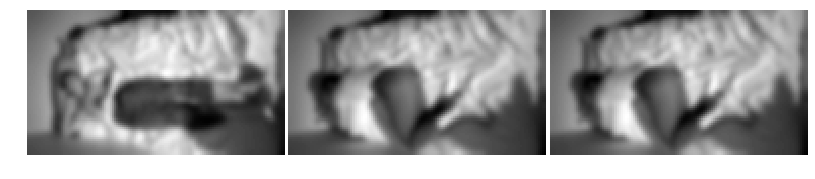

1617348
1601053
839513


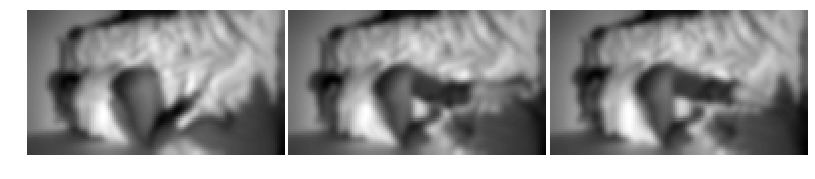

1582980
1579714
227390


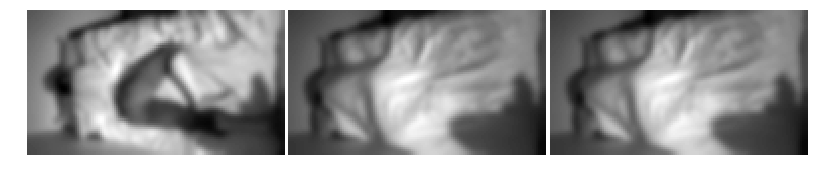

1411975
1371715
1912764


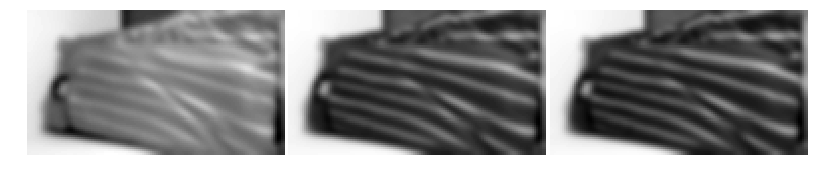

1481479
1380694
83279


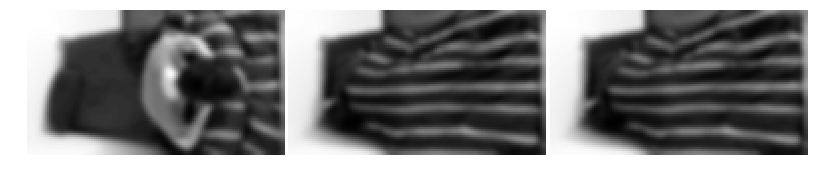

['/Volumes/NO NAME/sleeper/photos_processed/2019-02-20/156.jpg', '/Volumes/NO NAME/sleeper/photos_processed/2019-02-20/218.jpg', '/Volumes/NO NAME/sleeper/photos_processed/2019-02-20/256.jpg', '/Volumes/NO NAME/sleeper/photos_processed/2019-02-20/264.jpg', '/Volumes/NO NAME/sleeper/photos_processed/2019-02-20/281.jpg']
['/Volumes/NO NAME/sleeper/photos_processed/2019-02-20/157.jpg', '/Volumes/NO NAME/sleeper/photos_processed/2019-02-20/219.jpg', '/Volumes/NO NAME/sleeper/photos_processed/2019-02-20/257.jpg', '/Volumes/NO NAME/sleeper/photos_processed/2019-02-20/264.jpg', '/Volumes/NO NAME/sleeper/photos_processed/2019-02-20/282.jpg']


In [139]:
l = get_files_list(folder, t_frames_list)
elected = [elect_pose_frame(f,verbose=True,display_comparison=True) for f in l]
print(l)
print(elected)
# for f in l:
#     elected = elect_pose_frame(f)
#     print("{}".format(elected))